In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from process_data import process_data
from policy import LinUCB
from bandit import ContextualBandit
from util import get_ci

def single_run(bandit, policy, T=1000, num_trials=3, seed=2023):
    correctness = []
    final_correctness = []
    np.random.seed(seed)
    for i, trial_seed in enumerate(np.random.randint(1, 100, num_trials)):
        bandit.reset(seed=trial_seed)
        policy.reset()
        for t in tqdm(range(T)):
            fea, lab = bandit.present()
            arm = policy.predict(fea, lab, t)
            reward = bandit.pull(arm)                      
            policy.update(fea, arm, reward)
        final_correctness.append(bandit.correctness[-1])
        correctness.append(bandit.correctness)
    return final_correctness, correctness

def run(features, labels, T=1000, num_trials=3, seed=2023):
    np.random.seed(seed)
    plot_df = pd.DataFrame(columns=['Mode', 'Unit', 'Cor'])
    plot_dt = {}
    for mode in ['linear', 'exponential']:
        for reward_unit in [1, 3, 10, 30, 100]:
            linucb_cb = ContextualBandit(features=features, labels=labels, reward_mode=mode, reward_unit=reward_unit)
            linucb = LinUCB(num_features=linucb_cb.num_features, num_labels=linucb_cb.k)
            final_cors, cors = single_run(linucb_cb, linucb, T=T, num_trials=num_trials, seed=seed)
            plot_dt[mode+f' unit {reward_unit}'] = np.array(cors)
            for cor in final_cors:
                plot_df.loc[len(plot_df)] = [mode, str(reward_unit), cor]
    return plot_df, plot_dt


In [2]:
path = 'data/warfarin.csv'
features, labels = process_data(path)
plot_df, plot_dt = run(features, labels, T=features.shape[0], num_trials=3, seed=2023)

100%|██████████| 5528/5528 [00:20<00:00, 273.14it/s]


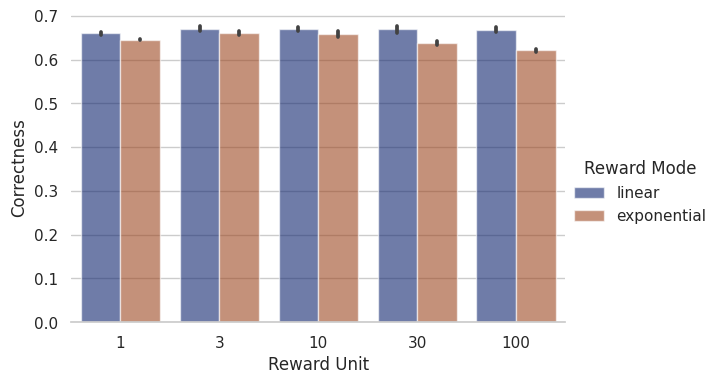

In [9]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=plot_df, kind="bar",
    x="Unit", y="Cor", hue="Mode",
    errorbar="sd", palette="dark", alpha=.6, height=4, aspect=6/4
)
g.despine(left=True)
g.set_axis_labels("Reward Unit", "Correctness")
g.legend.set_title("Reward Mode")

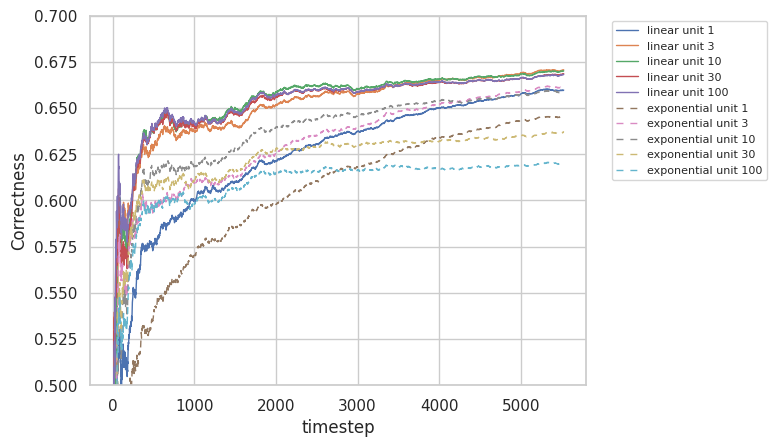

In [21]:
def plot_ci(plot_data, confidence=0.95):
    
    for model, dt in plot_data.items():
        T = dt.shape[1]
        means = np.apply_along_axis(np.mean, 0, dt)
        low_ci = np.apply_along_axis(get_ci, 0, dt, kind='low', confidence=confidence)
        high_ci = np.apply_along_axis(get_ci, 0, dt, kind='high', confidence=confidence)
        
        if model.startswith('exp'):
            linestyle = (0, (5, 5))
            linewidth = 1
        else:
            linestyle = None
            linewidth = 1
        
        plt.plot(range(T), means, label=model, linestyle=linestyle, linewidth=linewidth)
        # plt.fill_between(range(T), low_ci, high_ci, alpha=.1)
        
    plt.legend(bbox_to_anchor=(1.04,1), prop={'size': 8})   
    plt.ylim([0.5, 0.7])
    plt.xlabel('timestep')
    plt.ylabel('Correctness')
    plt.show()

plot_ci(plot_data=plot_dt)